In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import math as m
import vice
import sys
load_style_sheet("papers")
print(sys.version_info)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
outputs = [
    "../outputs/constant/vgas-1",
    "../outputs/angular-momentum-dilution/insideout-lowl",
    "../outputs/river/insideout"
]
outputs = [vice.output(name) for name in outputs]

In [3]:
def get_velocity_profile(output, lookback):
    raw = np.genfromtxt("%s_gasvelocities.out" % (output.name))
    time = output.zones["zone0"].history["time"][-1] - lookback
    diff = [abs(_ - time) for _ in output.zones["zone0"].history["time"]]
    idx = diff.index(min(diff))
    time = output.zones["zone0"].history["time"][idx]
    # print(time)
    radii = []
    vgas = []
    for i in range(len(raw)):
        if raw[i][0] == time:
            radii.append(raw[i][1])
            vgas.append(raw[i][2])
        else: pass
    return [radii, vgas]

def mu(output, lookback, zone_width = 0.1):
    radii, vgas = get_velocity_profile(output, lookback)
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    mu_gas = []
    mu_oxygen = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        neighbor = output.zones["zone%d" % (i + 1)]
        if radii[i + 1] >= 15.5:
            mu_gas.append(float("nan"))
            mu_oxygen.append(float("nan"))
        else:
            tau_star = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            mu = (neighbor.history["mgas"][idx] - zone.history["mgas"][idx]) / (zone.history["mgas"][idx] * zone_width)
            mu += (vgas[i + 1] - vgas[i]) / (vgas[i] * zone_width)
            mu *= -tau_star * vgas[i]
            mu_gas.append(mu)
            mu -= tau_star * vgas[i] * (
                neighbor.history["z(o)"][idx] - zone.history["z(o)"][idx]) / (zone.history["z(o)"][idx] * zone_width)
            mu_oxygen.append(mu)
    return [radii, mu_gas, mu_oxygen]

def eq_profile(output, lookback, zone_width = 0.1):
    radii, _, mu_o = mu(output, lookback, zone_width = zone_width)
    eq = len(radii) * [output.zones["zone0"].ccsne_yields["o"]]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    for i in range(len(radii) - 1):
        eta = output.zones["zone%d" % (i)].history["eta_0"][idx]
        eq[i] /= 1 + eta - mu_o[i] - 0.4
        if eq[i] > 0:
            eq[i] = np.log10(eq[i] / vice.solar_z["o"])
        else:
            eq[i] = float("nan")
    return [radii, eq]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_6337/2774805818.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  mu += (vgas[i + 1] - vgas[i]) / (vgas[i] * zone_width)
/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_6337/2774805818.py:33: RuntimeWarning: invalid value encountered in scalar multiply
  mu *= -tau_star * vgas[i]
/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_6337/1985172801.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


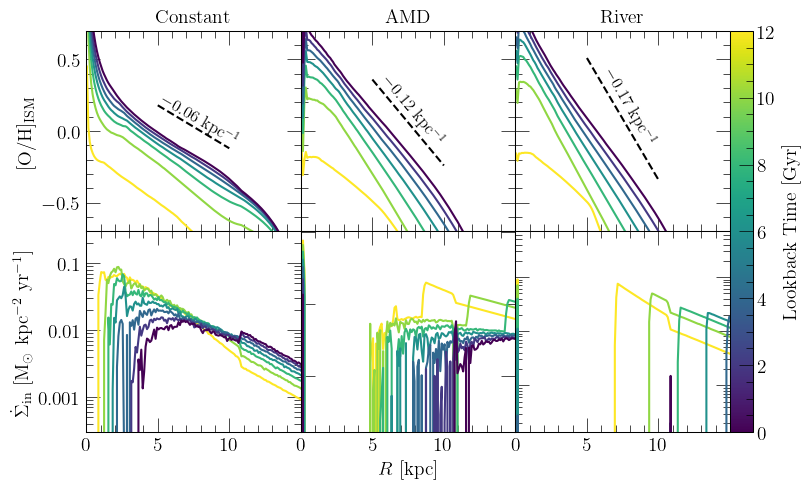

In [4]:
LOOKBACKS = [12, 10, 8, 6, 4, 2, 0]
COLORMAP = "viridis"
TITLES = ["Constant", "AMD", "River"]
SLOPES = [-0.06, -0.12, -0.17]

# fig = plt.figure(figsize = (7.5, 7.5))
fig = plt.figure(figsize = (7.5, 5))
top = len(outputs) * [None]
middle = len(outputs) * [None]
bottom = len(outputs) * [None]
for i in range(len(outputs)):
    kwargs = {}
    if i:
        kwargs["sharex"] = top[0]
        kwargs["sharey"] = top[0]
    else: pass
    top[i] = fig.add_subplot(201 + 10 * len(outputs) + i, **kwargs)
    top[i].set_title(TITLES[i])
    plt.setp(top[i].get_xticklabels(), visible = False)
    kwargs["sharex"] = top[0]
    if i:
        plt.setp(top[i].get_yticklabels(), visible = False)
        kwargs["sharey"] = middle[0]
    # middle[i] = fig.add_subplot(304 + 10 * len(outputs) + i, **kwargs)
    # plt.setp(middle[i].get_xticklabels(), visible = False)
    # middle[i].set_yscale("log")
    # if i:
    #     plt.setp(middle[i].get_yticklabels(), visible = False)
    #     kwargs["sharey"] = bottom[0]
    # else: pass
    bottom[i] = fig.add_subplot(204 + 10 * len(outputs) + i, **kwargs)
    bottom[i].set_yscale("log")
    if i: plt.setp(bottom[i].get_yticklabels(), visible = False)
    top[i].tick_params(zorder = 1000)
    bottom[i].tick_params(zorder = 1000)
top[0].set_ylabel(r"[O/H]$_\text{ISM}$")
# middle[0].set_ylabel(r"$v_{r,g}$ [km/s]")
bottom[0].set_ylabel(r"$\dot \Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
top[0].set_ylim([-0.7, 0.7])
top[0].set_xlim([0, 15])
top[0].set_xticks([0, 5, 10])
bottom[0].set_ylim([3.e-4, 0.3])
bottom[0].yaxis.set_major_formatter(fsf("%g"))
bottom[len(outputs) // 2].set_xlabel(r"$R$ [kpc]")

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.6])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "vertical")
cbar.set_label("Lookback Time [Gyr]")

def plot_snapshot(ax_oh, ax_in, output, lookback, zone_width = 0.1, **kwargs):
    radii, eq = eq_profile(output, lookback, zone_width = zone_width)
    _, vgas = get_velocity_profile(output, lookback)
    vgas = [-v for v in vgas]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    oh = len(radii) * [0.]
    sigma_in = len(radii) * [0.]
    for i in range(len(radii)):
        area = np.pi * ((radii[i] + zone_width)**2 - radii[i]**2)
        zone = output.zones["zone%d" % (i)]
        sigma_in[i] = zone.history["ifr"][idx] / area
        oh[i] = zone.history["[o/h]"][idx]
    radii = [r + zone_width / 2 for r in radii]
    ax_oh.plot(radii, oh, **kwargs)
    # ax_v.plot(radii, vgas, **kwargs)
    ax_in.plot(radii, sigma_in, **kwargs)

for i in range(len(outputs)):
    for j in range(len(LOOKBACKS)):
        kwargs = {"c": cmap.to_rgba(LOOKBACKS[j])}
        plot_snapshot(top[i], bottom[i], outputs[i], LOOKBACKS[j], **kwargs)

xvals = np.linspace(5, 10, 100)
for i in range(len(SLOPES)):
    yvals = [SLOPES[i] * (r - 8) for r in xvals]
    top[i].plot(xvals, yvals, c = named_colors()["black"], linestyle = "--")
top[0].text(5, -0.1, r"$%.2f$ kpc$^{-1}$" % (SLOPES[0]), fontsize = 12, rotation = -30)
top[1].text(5.5, -0.1, r"$%.2f$ kpc$^{-1}$" % (SLOPES[1]), fontsize = 12, rotation = -50)
top[2].text(6, -0.1, r"$%.2f$ kpc$^{-1}$" % (SLOPES[2]), fontsize = 12, rotation = -60)

plt.tight_layout()
# for i in range(len(outputs)): negative_log(middle[i])
plt.subplots_adjust(hspace = 0, wspace = 0)
cbar_ax.set_position([
    top[-1].get_position().x1,
    bottom[-1].get_position().y0,
    0.03,
    top[-1].get_position().y1 - bottom[-1].get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./metal-and-inflow-profiles/z-ifr-profile-relation.%s" % (ext), **kwargs)
plt.show()